# AI-Based Credit Risk Assessment using Application & Credit History Data

This notebook builds an end-to-end **credit risk assessment system** using two datasets:

- `application_record.csv`: one row per customer with demographic and financial information  
- `credit_record.csv`: multiple rows per customer with monthly credit status history

We will:
1. Understand and clean the data  
2. Construct a **default label** from credit history  
3. Engineer features from both application and credit behavior  
4. Handle **class imbalance** using SMOTE  
5. Train **Logistic Regression** and **Random Forest** models  
6. Evaluate with ROC–AUC, Precision–Recall AUC, and classification metrics  
7. Use **SHAP** for model interpretability  
8. Export the trained model for deployment.

> Make sure `application_record.csv` and `credit_record.csv` are in the **same folder** as this notebook.

In [2]:
# ============================================================
# 0. Setup & Imports
# ============================================================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    classification_report, confusion_matrix, roc_curve
)

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import joblib

sns.set(style='whitegrid')
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 160)

print('Imports loaded.')

Imports loaded.


## 1. Load Raw Data

We load the two source files and quickly inspect their structure.

- `application_record.csv`: one row per **applicant**
- `credit_record.csv`: multiple rows per applicant, one per **month of credit history** with a `STATUS` code.

In [3]:
# ============================================================
# 1. Load Data
# ============================================================

APP_PATH = 'application_record.csv'
CRED_PATH = 'credit_record.csv'

app_df = pd.read_csv(APP_PATH)
credit_df = pd.read_csv(CRED_PATH)

print('Application data shape:', app_df.shape)
print('Credit history data shape:', credit_df.shape)

display(app_df.head())
display(credit_df.head())

Application data shape: (438557, 18)
Credit history data shape: (1048575, 3)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [4]:
# Basic info / schema

print('=== application_record info ===')
app_df.info()
print('\n=== credit_record info ===')
credit_df.info()

print('\napplication_record columns:', app_df.columns.tolist())
print('credit_record columns:', credit_df.columns.tolist())

=== application_record info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null

### Understanding `STATUS` and `MONTHS_BALANCE`

- `STATUS` is a monthly repayment status code per customer & month:
  - `"0"` – paid on time  
  - `"1"`–`"5"` – payment late by 1–5+ months  
  - `"C"` – contract closed  
  - `"X"` – no loan for that month / no data

- `MONTHS_BALANCE` is the month index relative to a reference point:
  - `0` → current month, `-1` → 1 month ago, `-2` → 2 months ago, etc.

We will use `STATUS` to build our **default label**.

## 2. Build Customer-Level Default Label

We treat a customer as a **defaulter** if they ever have a `STATUS` code of `2` or more
in their `credit_record` (i.e. more than 60 days overdue).

Steps:
1. Convert `STATUS` to string  
2. Map each row to a `default_event` (0/1)  
3. Aggregate to customer-level `default_flag` = max of `default_event` per `ID`  
4. Merge this label into the `application_record` data.

In [5]:
# ============================================================
# 2. Build Default Label from credit_record
# ============================================================

# Ensure STATUS is string
credit_df['STATUS'] = credit_df['STATUS'].astype(str)

def status_to_default(status: str) -> int:
    """Map raw STATUS to binary default flag for that month.
    1 = default (risky), 0 = not default.
    """
    if status in ['2', '3', '4', '5']:
        return 1
    else:
        return 0

credit_df['default_event'] = credit_df['STATUS'].apply(status_to_default)

credit_df[['ID', 'MONTHS_BALANCE', 'STATUS', 'default_event']].head()

,ID,MONTHS_BALANCE,STATUS,default_event
0,5001711,0,X,0
1,5001711,-1,0,0
2,5001711,-2,0,0
3,5001711,-3,0,0
4,5001712,0,C,0


In [6]:
# Aggregate to customer-level: if customer ever defaulted in any month -> default_flag = 1

customer_default = (
    credit_df
    .groupby('ID')['default_event']
    .max()
    .reset_index()
    .rename(columns={'default_event': 'default_flag'})
)

print('Customer-level default_flag distribution:')
display(customer_default['default_flag'].value_counts())
print('\nProportions:')
display(customer_default['default_flag'].value_counts(normalize=True).round(4))

Customer-level default_flag distribution:


default_flag
0    45318
1      667
Name: count, dtype: int64


Proportions:


default_flag
0    0.9855
1    0.0145
Name: proportion, dtype: float64

In [7]:
# Merge label into application data (inner join: only customers with credit history)

data = app_df.merge(customer_default, on='ID', how='inner')
print('Merged dataset shape:', data.shape)

display(data['default_flag'].value_counts())
display((data['default_flag'].value_counts(normalize=True) * 100).round(2))

Merged dataset shape: (36457, 19)


default_flag
0    35841
1      616
Name: count, dtype: int64

default_flag
0    98.31
1     1.69
Name: proportion, dtype: float64

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,default_flag
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


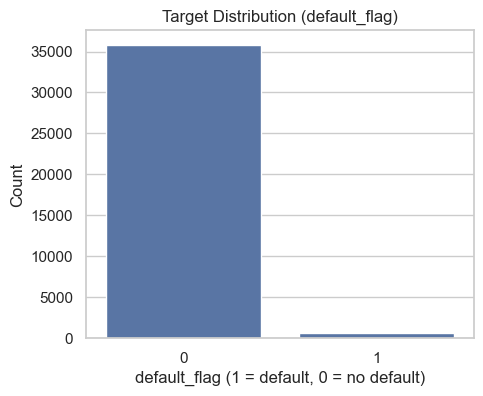

In [8]:
# Quick look at merged data and target distribution

display(data.head())

plt.figure(figsize=(5,4))
sns.countplot(x='default_flag', data=data)
plt.title('Target Distribution (default_flag)')
plt.xlabel('default_flag (1 = default, 0 = no default)')
plt.ylabel('Count')
plt.show()

## 3. Application Data Cleaning & Feature Engineering

We:
- Keep `ID` separately and remove it from features  
- Convert day-based columns into interpretable `AGE_YEARS` and `YEARS_EMPLOYED`  
- Create income ratios (`INCOME_PER_CHILD`, `INCOME_PER_FAM_MEMBER`)  
- Clip extreme incomes to reduce outlier impact  
- Handle missing values and encode categorical features.

In [9]:
# ============================================================
# 3.1 Basic cleaning & feature engineering on application data
# ============================================================

# Keep a copy of IDs
ids = data['ID']
data = data.drop(columns=['ID'])

# Handle missing OCCUPATION_TYPE
if 'OCCUPATION_TYPE' in data.columns:
    data['OCCUPATION_TYPE'] = data['OCCUPATION_TYPE'].fillna('Unknown')

# Convert DAYS_BIRTH and DAYS_EMPLOYED into years
if 'DAYS_BIRTH' in data.columns:
    data['AGE_YEARS'] = (-data['DAYS_BIRTH']) / 365
    data = data.drop(columns=['DAYS_BIRTH'])

if 'DAYS_EMPLOYED' in data.columns:
    data['YEARS_EMPLOYED'] = np.where(
        data['DAYS_EMPLOYED'] > 0,
        0,
        -data['DAYS_EMPLOYED'] / 365
    )
    data = data.drop(columns=['DAYS_EMPLOYED'])

# Income-based ratios
if 'AMT_INCOME_TOTAL' in data.columns and 'CNT_CHILDREN' in data.columns:
    data['INCOME_PER_CHILD'] = data['AMT_INCOME_TOTAL'] / (1 + data['CNT_CHILDREN'])

if 'AMT_INCOME_TOTAL' in data.columns and 'CNT_FAM_MEMBERS' in data.columns:
    data['INCOME_PER_FAM_MEMBER'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']

# Clip extreme incomes at 99th percentile
if 'AMT_INCOME_TOTAL' in data.columns:
    q99 = data['AMT_INCOME_TOTAL'].quantile(0.99)
    data['AMT_INCOME_TOTAL_CLIPPED'] = np.minimum(data['AMT_INCOME_TOTAL'], q99)

print('Basic engineered features added.')
display(data.head())

Basic engineered features added.


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,default_flag,AGE_YEARS,YEARS_EMPLOYED,INCOME_PER_CHILD,INCOME_PER_FAM_MEMBER,AMT_INCOME_TOTAL_CLIPPED
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,0,32.890411,12.443836,427500.0,213750.0,427500.0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,0,32.890411,12.443836,427500.0,213750.0,427500.0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,58.832877,3.106849,112500.0,56250.0,112500.0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52.356164,8.358904,270000.0,270000.0,270000.0
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52.356164,8.358904,270000.0,270000.0,270000.0


In [10]:
# Identify categorical vs numeric columns

target_col = 'default_flag'
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in data.columns if c not in cat_cols + [target_col]]

print('Categorical columns:', cat_cols)
print('Numeric columns (first 15):', num_cols[:15])

missing_counts = data.isna().sum().sort_values(ascending=False)
print('\nMissing values per column (top 20):')
display(missing_counts.head(20))

Categorical columns: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
Numeric columns (first 15): ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE_YEARS', 'YEARS_EMPLOYED', 'INCOME_PER_CHILD', 'INCOME_PER_FAM_MEMBER', 'AMT_INCOME_TOTAL_CLIPPED']

Missing values per column (top 20):


CODE_GENDER              0
FLAG_OWN_CAR             0
FLAG_OWN_REALTY          0
CNT_CHILDREN             0
AMT_INCOME_TOTAL         0
NAME_INCOME_TYPE         0
NAME_EDUCATION_TYPE      0
NAME_FAMILY_STATUS       0
NAME_HOUSING_TYPE        0
FLAG_MOBIL               0
FLAG_WORK_PHONE          0
FLAG_PHONE               0
FLAG_EMAIL               0
OCCUPATION_TYPE          0
CNT_FAM_MEMBERS          0
default_flag             0
AGE_YEARS                0
YEARS_EMPLOYED           0
INCOME_PER_CHILD         0
INCOME_PER_FAM_MEMBER    0
dtype: int64

In [11]:
# ============================================================
# 3.2 Handle missing values
# ============================================================

# Fill numeric NaNs with median
for col in num_cols:
    if data[col].isna().sum() > 0:
        data[col] = data[col].fillna(data[col].median())

# Fill categorical NaNs with 'Unknown'
for col in cat_cols:
    data[col] = data[col].fillna('Unknown')

print('Total remaining missing values:', data.isna().sum().sum())

# Encode categoricals with LabelEncoder
le_map = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    le_map[col] = le

print('Encoded all categorical features.')
display(data.head())

Total remaining missing values: 0
Encoded all categorical features.


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,default_flag,AGE_YEARS,YEARS_EMPLOYED,INCOME_PER_CHILD,INCOME_PER_FAM_MEMBER,AMT_INCOME_TOTAL_CLIPPED
0,1,1,1,0,427500.0,4,1,0,4,1,1,0,0,17,2.0,0,32.890411,12.443836,427500.0,213750.0,427500.0
1,1,1,1,0,427500.0,4,1,0,4,1,1,0,0,17,2.0,0,32.890411,12.443836,427500.0,213750.0,427500.0
2,1,1,1,0,112500.0,4,4,1,1,1,0,0,0,16,2.0,0,58.832877,3.106849,112500.0,56250.0,112500.0
3,0,0,1,0,270000.0,0,4,3,1,1,0,1,1,14,1.0,0,52.356164,8.358904,270000.0,270000.0,270000.0
4,0,0,1,0,270000.0,0,4,3,1,1,0,1,1,14,1.0,0,52.356164,8.358904,270000.0,270000.0,270000.0


## 4. Credit History Feature Engineering

From `credit_record`, we create customer-level behavioral features:

- `num_delay_months`: how many months had a delay (`STATUS` in `1–5`)  
- `delay_ratio`: fraction of months with delay  
- `max_delay_severity`: worst observed delay level  
- `credit_history_length`: span in months between oldest and newest record  
- `months_with_records`: number of months with any status.

In [12]:
# ============================================================
# 4.1 Aggregate credit_record by customer
# ============================================================

credit_df['STATUS'] = credit_df['STATUS'].astype(str)
credit_df['delay_flag'] = credit_df['STATUS'].isin(['1', '2', '3', '4', '5']).astype(int)

agg_funcs = {
    'MONTHS_BALANCE': ['min', 'max', 'nunique'],
    'delay_flag': ['sum', 'mean']
}

credit_agg = credit_df.groupby('ID').agg(agg_funcs)
credit_agg.columns = ['_'.join(col) for col in credit_agg.columns]
credit_agg.reset_index(inplace=True)

credit_agg.head()

,ID,MONTHS_BALANCE_min,MONTHS_BALANCE_max,MONTHS_BALANCE_nunique,delay_flag_sum,delay_flag_mean
0,5001711,-3,0,4,0,0.0
1,5001712,-18,0,19,0,0.0
2,5001713,-21,0,22,0,0.0
3,5001714,-14,0,15,0,0.0
4,5001715,-59,0,60,0,0.0


In [13]:
# Add max_delay_severity: worst observed delay level per customer

def status_severity(s: str) -> int:
    if s in ['X', 'C', '0']:
        return 0
    try:
        return int(s)
    except:
        return 0

credit_df['delay_severity'] = credit_df['STATUS'].apply(status_severity)

max_delay = (
    credit_df
    .groupby('ID')['delay_severity']
    .max()
    .reset_index()
    .rename(columns={'delay_severity': 'max_delay_severity'})
)

credit_agg = credit_agg.merge(max_delay, on='ID', how='left')
credit_agg.head()

,ID,MONTHS_BALANCE_min,MONTHS_BALANCE_max,MONTHS_BALANCE_nunique,delay_flag_sum,delay_flag_mean,max_delay_severity
0,5001711,-3,0,4,0,0.0,0
1,5001712,-18,0,19,0,0.0,0
2,5001713,-21,0,22,0,0.0,0
3,5001714,-14,0,15,0,0.0,0
4,5001715,-59,0,60,0,0.0,0


In [14]:
# Rename aggregated columns & derive credit_history_length

credit_agg.rename(columns={
    'MONTHS_BALANCE_min': 'credit_history_oldest_month',
    'MONTHS_BALANCE_max': 'credit_history_newest_month',
    'MONTHS_BALANCE_nunique': 'months_with_records',
    'delay_flag_sum': 'num_delay_months',
    'delay_flag_mean': 'delay_ratio',
}, inplace=True)

credit_agg['credit_history_length'] = (
    credit_agg['credit_history_newest_month'] - credit_agg['credit_history_oldest_month']
).abs()

credit_feat_cols = [
    'credit_history_oldest_month',
    'credit_history_newest_month',
    'months_with_records',
    'num_delay_months',
    'delay_ratio',
    'max_delay_severity',
    'credit_history_length'
]

credit_agg[credit_feat_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
credit_history_oldest_month,45985.0,-26.433489,16.481280,-60.0,-40.0,-25.0,-12.0,0.0
credit_history_newest_month,45985.0,-4.630945,10.355319,-60.0,-1.0,0.0,0.0,0.0
months_with_records,45985.0,22.802544,15.492771,1.0,10.0,19.0,34.0,61.0
num_delay_months,45985.0,0.308666,1.512753,0.0,0.0,0.0,0.0,49.0
delay_ratio,45985.0,0.014548,0.061152,0.0,0.0,0.0,0.0,1.0
max_delay_severity,45985.0,0.147570,0.499229,0.0,0.0,0.0,0.0,5.0
credit_history_length,45985.0,21.802544,15.492771,0.0,9.0,18.0,33.0,60.0


In [15]:
# ============================================================
# 4.2 Merge credit aggregates into main data
# ============================================================

data_with_ids = pd.concat([ids, data], axis=1)
full = data_with_ids.merge(credit_agg, on='ID', how='left')

print('Full dataset shape (with credit features):', full.shape)

for col in credit_feat_cols:
    full[col] = full[col].fillna(0)

display(full.head())

Full dataset shape (with credit features): (36457, 29)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,default_flag,AGE_YEARS,YEARS_EMPLOYED,INCOME_PER_CHILD,INCOME_PER_FAM_MEMBER,AMT_INCOME_TOTAL_CLIPPED,credit_history_oldest_month,credit_history_newest_month,months_with_records,num_delay_months,delay_ratio,max_delay_severity,credit_history_length
0,5008804,1,1,1,0,427500.0,4,1,0,4,1,1,0,0,17,2.0,0,32.890411,12.443836,427500.0,213750.0,427500.0,-15,0,16,1,0.062500,1,15
1,5008805,1,1,1,0,427500.0,4,1,0,4,1,1,0,0,17,2.0,0,32.890411,12.443836,427500.0,213750.0,427500.0,-14,0,15,1,0.066667,1,14
2,5008806,1,1,1,0,112500.0,4,4,1,1,1,0,0,0,16,2.0,0,58.832877,3.106849,112500.0,56250.0,112500.0,-29,0,30,0,0.000000,0,29
3,5008808,0,0,1,0,270000.0,0,4,3,1,1,0,1,1,14,1.0,0,52.356164,8.358904,270000.0,270000.0,270000.0,-4,0,5,0,0.000000,0,4
4,5008809,0,0,1,0,270000.0,0,4,3,1,1,0,1,1,14,1.0,0,52.356164,8.358904,270000.0,270000.0,270000.0,-26,-22,5,0,0.000000,0,4


## 5. Prepare Data for Modeling

We:
- Drop helper columns like `ID` and `AGE_BIN` (if created)  
- Define `X` (features) and `y` (target)  
- Split into train / validation / test (60 / 20 / 20)  
- Apply **SMOTE** to the training set  
- Scale features for Logistic Regression.

In [16]:
# ============================================================
# 5.1 Define X, y and train/val/test split
# ============================================================

target_col = 'default_flag'

if 'ID' in full.columns:
    full_n = full.drop(columns=['ID'])
else:
    full_n = full.copy()

if 'AGE_BIN' in full_n.columns:
    full_n = full_n.drop(columns=['AGE_BIN'])

feature_cols = [c for c in full_n.columns if c != target_col]
X_all = full_n[feature_cols]
y_all = full_n[target_col]

print('Feature matrix shape:', X_all.shape)
print('Target vector shape:', y_all.shape)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25,
    random_state=42,
    stratify=y_train_val
)

print('Train shape:', X_train.shape)
print('Val shape:', X_val.shape)
print('Test shape:', X_test.shape)

print('\nTrain target distribution:')
print(y_train.value_counts(normalize=True).round(4))

Feature matrix shape: (36457, 27)
Target vector shape: (36457,)
Train shape: (21873, 27)
Val shape: (7292, 27)
Test shape: (7292, 27)

Train target distribution:
default_flag
0    0.9831
1    0.0169
Name: proportion, dtype: float64


In [17]:
# ============================================================
# 5.2 SMOTE on training set & scaling
# ============================================================

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print('After SMOTE, train target distribution:')
print(y_train_sm.value_counts(normalize=True).round(4))

scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print('Scaling complete.')

After SMOTE, train target distribution:
default_flag
0    0.5
1    0.5
Name: proportion, dtype: float64
Scaling complete.


## 6. Baseline Models: Logistic Regression & Random Forest

We train:

1. **Logistic Regression** – fast, interpretable baseline  
2. **Random Forest** – non-linear ensemble model

We compare ROC–AUC, PR–AUC, and classification metrics.

Logistic Regression - Val ROC-AUC: 1.0000
Logistic Regression - Val PR-AUC: 1.0000

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7169
           1       1.00      1.00      1.00       123

    accuracy                           1.00      7292
   macro avg       1.00      1.00      1.00      7292
weighted avg       1.00      1.00      1.00      7292



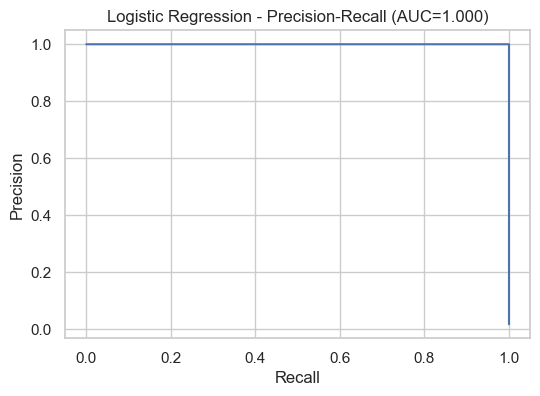

In [18]:
# ============================================================
# 6.1 Logistic Regression (baseline)
# ============================================================

log_reg = LogisticRegression(
    max_iter=500,
    class_weight='balanced',
    n_jobs=-1
)

log_reg.fit(X_train_sm_scaled, y_train_sm)

val_prob_lr = log_reg.predict_proba(X_val_scaled)[:, 1]
val_pred_lr = (val_prob_lr >= 0.5).astype(int)

roc_lr = roc_auc_score(y_val, val_prob_lr)
prec_lr, rec_lr, thr_lr = precision_recall_curve(y_val, val_prob_lr)
pr_auc_lr = auc(rec_lr, prec_lr)

print(f'Logistic Regression - Val ROC-AUC: {roc_lr:.4f}')
print(f'Logistic Regression - Val PR-AUC: {pr_auc_lr:.4f}')
print('\nClassification report (threshold=0.5):')
print(classification_report(y_val, val_pred_lr))

plt.figure(figsize=(6,4))
plt.plot(rec_lr, prec_lr)
plt.title(f'Logistic Regression - Precision-Recall (AUC={pr_auc_lr:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Random Forest - Val ROC-AUC: 1.0000
Random Forest - Val PR-AUC: 1.0000

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7169
           1       1.00      1.00      1.00       123

    accuracy                           1.00      7292
   macro avg       1.00      1.00      1.00      7292
weighted avg       1.00      1.00      1.00      7292



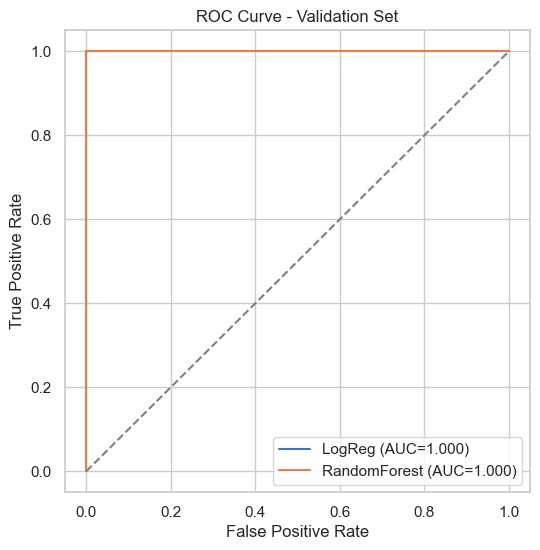

In [20]:
# ============================================================
# 6.2 Random Forest
# ============================================================

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=50,
    min_samples_leaf=20,
    n_jobs=-1,
    class_weight='balanced_subsample',
    random_state=42
)

rf.fit(X_train_sm, y_train_sm)

val_prob_rf = rf.predict_proba(X_val)[:, 1]
val_pred_rf = (val_prob_rf >= 0.5).astype(int)

roc_rf = roc_auc_score(y_val, val_prob_rf)
prec_rf, rec_rf, thr_rf = precision_recall_curve(y_val, val_prob_rf)
pr_auc_rf = auc(rec_rf, prec_rf)

print(f'Random Forest - Val ROC-AUC: {roc_rf:.4f}')
print(f'Random Forest - Val PR-AUC: {pr_auc_rf:.4f}')
print('\nClassification report (threshold=0.5):')
print(classification_report(y_val, val_pred_rf))

fpr_lr, tpr_lr, _ = roc_curve(y_val, val_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, val_prob_rf)

plt.figure(figsize=(6,6))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={roc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={roc_rf:.3f})')
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend()
plt.show()

## 7. Threshold Tuning & Test Evaluation

In credit risk, **recall on defaulters** is more important than accuracy.
We scan different thresholds on the validation set and then evaluate on the test set.

In [21]:
# Try different thresholds for Random Forest on validation set

for thr in [0.2, 0.3, 0.4, 0.5]:
    preds_thr = (val_prob_rf >= thr).astype(int)
    print('='*50)
    print(f'Threshold: {thr}')
    print(classification_report(y_val, preds_thr, digits=3))


Threshold: 0.2
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      7169
           1      0.976     1.000     0.988       123

    accuracy                          1.000      7292
   macro avg      0.988     1.000     0.994      7292
weighted avg      1.000     1.000     1.000      7292

Threshold: 0.3
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      7169
           1      1.000     1.000     1.000       123

    accuracy                          1.000      7292
   macro avg      1.000     1.000     1.000      7292
weighted avg      1.000     1.000     1.000      7292

Threshold: 0.4
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      7169
           1      1.000     1.000     1.000       123

    accuracy                          1.000      7292
   macro avg      1.000     1.000     1.000      7292
weighted avg      1.000     1

Random Forest - Test ROC-AUC: 1.0000
Random Forest - Test PR-AUC: 1.0000

Classification report (threshold=0.3):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      7169
           1      1.000     1.000     1.000       123

    accuracy                          1.000      7292
   macro avg      1.000     1.000     1.000      7292
weighted avg      1.000     1.000     1.000      7292



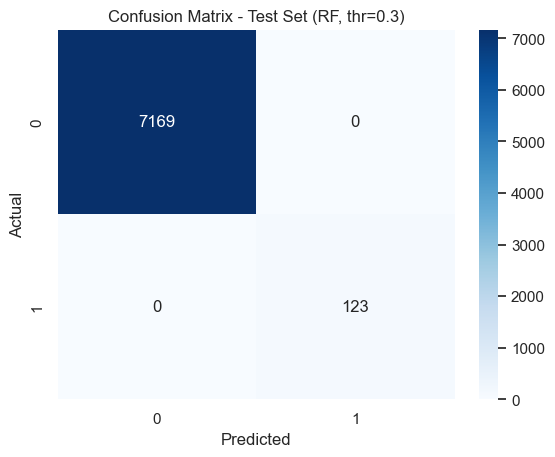

In [22]:
# Evaluate on test set with chosen threshold

chosen_thr = 0.3
test_prob_rf = rf.predict_proba(X_test)[:, 1]
test_pred_rf = (test_prob_rf >= chosen_thr).astype(int)

roc_test = roc_auc_score(y_test, test_prob_rf)
prec_test, rec_test, thr_test = precision_recall_curve(y_test, test_prob_rf)
pr_auc_test = auc(rec_test, prec_test)

print(f'Random Forest - Test ROC-AUC: {roc_test:.4f}')
print(f'Random Forest - Test PR-AUC: {pr_auc_test:.4f}')
print('\nClassification report (threshold=0.3):')
print(classification_report(y_test, test_pred_rf, digits=3))

cm = confusion_matrix(y_test, test_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set (RF, thr=0.3)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Feature Importance

We examine which features drive the Random Forest model.

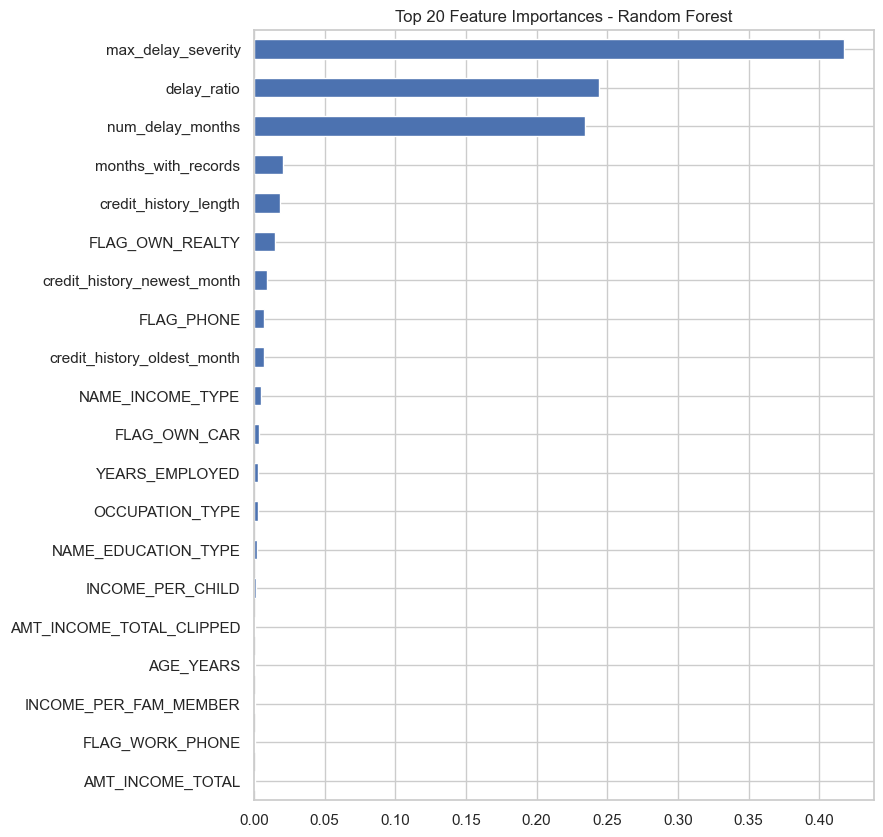

max_delay_severity             0.417642
delay_ratio                    0.244472
num_delay_months               0.234272
months_with_records            0.020413
credit_history_length          0.018389
FLAG_OWN_REALTY                0.014750
credit_history_newest_month    0.009430
FLAG_PHONE                     0.007448
credit_history_oldest_month    0.007045
NAME_INCOME_TYPE               0.005096
FLAG_OWN_CAR                   0.003740
YEARS_EMPLOYED                 0.003151
OCCUPATION_TYPE                0.003061
NAME_EDUCATION_TYPE            0.002197
INCOME_PER_CHILD               0.001391
AMT_INCOME_TOTAL_CLIPPED       0.001161
AGE_YEARS                      0.001136
INCOME_PER_FAM_MEMBER          0.001076
FLAG_WORK_PHONE                0.001062
AMT_INCOME_TOTAL               0.000941
dtype: float64

In [23]:
feat_importance = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8,10))
feat_importance.head(20).plot(kind='barh')
plt.title('Top 20 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.show()

feat_importance.head(20)

## 9. Model Explainability with SHAP

We use SHAP (SHapley Additive exPlanations) to understand **why** the model gives a high/low risk score.

In [24]:
# !pip install shap  # uncomment if SHAP is not installed
import shap

explainer = shap.TreeExplainer(rf)
X_test_sample = X_test.sample(300, random_state=42)
shap_values = explainer.shap_values(X_test_sample)
print('SHAP values computed for a test sample.')

SHAP values computed for a test sample.


## 10. Export Trained Artifacts

We save the Random Forest model, scaler, and label encoders for deployment.

In [29]:
joblib.dump(rf, 'credit_risk_rf_model.pkl')
joblib.dump(scaler, 'credit_risk_scaler.pkl')
joblib.dump(le_map, 'credit_risk_label_encoders.pkl')

print('Saved model and preprocessing artifacts to disk.')

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Saved model and preprocessing artifacts to disk.


In [30]:
# ============================================================
# Save clean, model-ready dataset for the Streamlit app
# ============================================================

# This assumes 'full' still exists and contains:
# ID, all engineered features, and 'default_flag'

clean_path = "clean_credit_risk_dataset.csv"
full.to_csv(clean_path, index=False)

print(f"Saved clean dataset to {clean_path}")
print("Shape:", full.shape)


Saved clean dataset to clean_credit_risk_dataset.csv
Shape: (36457, 29)
